# Implement TensorFlow Model in Sagemaker with S3

Kernel: conda_amazonei_tensorflow2_p36

### Install packages

In [2]:
!pip install boto3 keras s3fs tensorflow pyprind

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 82.6 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.19
    Uninstalling botocore-1.24.19:
      Successfully uninstalled botocore-1.24.19
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.25.38 requires botocore==1.27.38, but you have botocore 1.27.43 which is incompatible.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.27.43 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.


### Import Statements

In [3]:
import os
import csv
import time
import sys
import random
import tempfile
import boto3
import pyprind
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import losses, layers, optimizers
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from PIL import ImageFile
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.preprocessing.image import load_img, img_to_array, smart_resize

### Hyperparams

In [4]:
S3_BUCKET = '76f71cf8-ac28-4d72-81a1-28db41a2e7c2'
IMG_SIZE = (320, 320)
classes = ['Cardiomegaly', 'nf']
class_dict = {}
for i, c in enumerate(classes):
    key = np.array([0 for i in range(len(classes))])
    key[i] = 1
    class_dict[c] = key # i
        
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
class_dict

{'Cardiomegaly': array([1, 0]), 'nf': array([0, 1])}

### Load Images Function (takes a few minutes)

In [6]:
def load_images(folder):
    '''
    Load num_images images from S3 and return X, y, and filename arrays. -1 is placeholder value.
    Bucket structure:
    $ tree
    .
    |---folder/
        |---train/
        |    |---class_1/
        |    |---class_2/
        |    |---...
        |---test/
             |---class_1/
             |---class_2/
             |---...
    '''
    # set up bucket
    s3 = boto3.client("s3")
    S3_PREFIX = folder
        
    paginator = s3.get_paginator('list_objects_v2')
    pages = paginator.paginate(Bucket=S3_BUCKET, Prefix=S3_PREFIX)

    # get all filenames from bucket
    s3_objects = []
    for page in pages:
        s3_objects += [obj["Key"] for obj in page["Contents"]]
    arr_size = len(s3_objects)
        
    X, y, filenames = [0]*arr_size, [0]*arr_size, [0]*arr_size
    
    # IMPORTANT: there must be a / at the end of Prefix! ex: 'Strictly_Mass_and_NF/test/'
    result = boto3.client("s3").list_objects(Bucket=S3_BUCKET, Prefix=S3_PREFIX, Delimiter='/')
        
    # create temp directory to not clog memory
    # Note: if the train or test folders are too large, may need to break this down into smaller chunks
    with tempfile.TemporaryDirectory() as tempdir:

        # create progress bar
        bar = pyprind.ProgBar(len(s3_objects), title="Loading Images", bar_char='█')
        bar_count = 0

        for i, s3_file in enumerate(s3_objects):
            split_name = s3_file.split('/')
            filename = split_name[-1]
            label = split_name[-2]
            local_file_path = os.path.join(tempdir, split_name[-1])
            s3.download_file(S3_BUCKET, s3_file, local_file_path)
            img = cv2.imread(local_file_path)
            res = cv2.resize(img, dsize=IMG_SIZE, interpolation=cv2.INTER_CUBIC)
            
#             image_generator = tf.io.read_file(local_file_path) 
#             tensor = tf.io.decode_image(image_generator, channels=3, dtype=tf.dtypes.float32)
#             tensor = tf.image.resize(tensor, [320, 320])
#             img_tensor = tf.expand_dims(tensor, axis=0)
            
#             return res, img_tensor
                
            # store values from each image
            X[i] = res #.reshape((3,)+IMG_SIZE)
            y[i] = class_dict[label]
            filenames[i] = filename

            # update progress bar
            bar_count += 1
            bar.update(item_id=bar_count)
#             if bar_count > num:
#                 break

        print(f"Loaded {bar_count} files.")
        
    # convert to arrays
    X = np.array(X)
    y = np.array(y)
    filenames = np.array(filenames)
        
    return X, y, filenames

data, labels, filenames = load_images('Strictly_Cardiomegaly_and_NF')
print(data.shape, labels.shape)

Loaded 1713 files.
(1713, 320, 320, 3) (1713, 2)


### Load model

In [117]:
model = tf.keras.models.load_model('best_model_v1.h5')
# model.load_weights('25_multi_catcross_weights.h5')

### Train, test, val split

In [9]:
# mini_X_train, mini_y_train = X_train[:100], y_train[:100]
x_train_and_val, x_test, y_train_and_val, y_test = train_test_split(data, labels, test_size=0.1, random_state=0)
x_train, x_val, y_train, y_val = train_test_split(x_train_and_val, y_train_and_val, test_size=0.11, random_state=0)

print('Train size:', x_train.shape[0])
print('Validation size:', x_val.shape[0])
print('Test size:', x_test.shape[0])

Train size: 1371
Validation size: 170
Test size: 172


### Evaluate Model 

In [10]:
BATCH_SIZE = 4

datagen = ImageDataGenerator(samplewise_center=True,
                                 samplewise_std_normalization=True,
#                                  dtype = 'int64',
                                )

# train_batches = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
# train_eval = model.evaluate_generator(train_batches, steps = len(train_batches))
# print(f'Train loss: {train_eval[0]}, Train accuracy: {train_eval[1]}')

# val_batches = datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, shuffle=False)
# val_eval = model.evaluate_generator(val_batches, steps = len(val_batches))
# print(f'Validation loss: {val_eval[0]}, Validation accuracy: {val_eval[1]}')

# val and test have the same transformations
test_batches = datagen.flow(x_test, y_test, batch_size=BATCH_SIZE, shuffle=False)
test_eval = model.evaluate_generator(test_batches, steps = len(test_batches))
print(f'Test loss: {test_eval[0]}, Test accuracy: {test_eval[1]}')

/home/ec2-user/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3, or 4 channels on axis 1. However, it was passed an array with shape (172, 320, 320, 3) (320 channels).
  warnings.warn('NumpyArrayIterator is set to use the '
/tmp/ipykernel_11454/1789312210.py:18: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_eval = model.evaluate_generator(test_batches, steps = len(test_batches))


Test loss: 0.4763128459453583, Test accuracy: 0.7906976938247681


### Get Confusion Matrix

In [118]:
from sklearn.metrics import confusion_matrix

# all_batches = datagen.flow(data, labels, batch_size=len(data), shuffle=False)
# all_pred = model.predict(next(all_batches)[0])

# # overall confusion matrix
# cm = confusion_matrix(np.argmin(labels, axis=1), np.argmin(all_pred, axis=1))
# TP, TN, FP, FN = cm[0][0], cm[1][1], cm[0][1], cm[1][0]
# print('For entire dataset')
# print('TP:', TP)
# print('TN:', TN)
# print('FP:', FP)
# print('FN:', FN)

# test_batches = datagen.flow(x_test, y_test, batch_size=len(x_test), shuffle=False)
# test_pred = model.predict(next(test_batches)[0])

TN, FP, FN, TP = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1)).ravel()
print('Confusion matrix for test set (No finding)')
print('TP:', TP)
print('TN:', TN)
print('FP:', FP)
print('FN:', FN)

/home/ec2-user/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras_preprocessing/image/numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_first" (channels on axis 1), i.e. expected either 1, 3, or 4 channels on axis 1. However, it was passed an array with shape (172, 320, 320, 3) (320 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


For test set (No finding)
TP: 66
TN: 67
FP: 20
FN: 19


In [119]:
# reverse axis so cardiomegaly is [0, 1] instead of the default [1, 0]
card_labels = y_test.copy()
card_labels[:, [1, 0]] = card_labels[:, [0, 1]]
card_pred = test_pred.copy()
card_pred[:, [1, 0]] = card_pred[:, [0, 1]]


TN, FP, FN, TP = confusion_matrix(np.argmax(card_labels, axis=1), np.argmax(card_pred, axis=1)).ravel()
print('Confusion matrix for test set (Cardiomegaly)')
print('TP:', TP)
print('TN:', TN)
print('FP:', FP)
print('FN:', FN)

For test set (Cardiomegaly)
TP: 67
TN: 66
FP: 19
FN: 20


In [120]:
# sanity check
tp, tn, fp, fn = 0, 0, 0, 0
for y, yhat in zip(y_test, test_pred):
    pred_card = yhat[0]
    true_card = y[0]
    if pred_card > 0.5:
        #tp or fp
        if true_card > 0.5:
            tp += 1
        else:
            fp += 1
    else: #pred_nf > 0.5
        #tn or fn
        if true_card > 0.5:
            fn += 1
        else:
            tn += 1    
print('Confusion matrix for test set (Cardiomegaly)')
print('TP:', tp)
print('TN:', tn)
print('FP:', fp)
print('FN:', fn)

For test set (Cardiomegaly)
TP: 67
TN: 66
FP: 19
FN: 20


### Get AUC Score and ROC Curve

In [121]:
from sklearn.metrics import roc_auc_score, roc_curve

# roc_auc_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))
nf_score = roc_auc_score(y_test, test_pred)
card_score = roc_auc_score(card_labels, card_pred)
print('NF roc_auc_score:', nf_score)
print('Cardiomegaly roc_auc_score:', card_score)

NF roc_auc_score: 0.857606490872211
Cardiomegaly roc_auc_score: 0.857606490872211


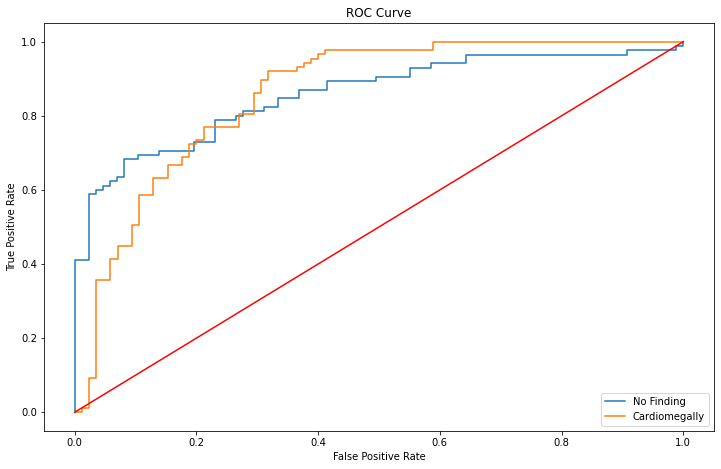

Confusion matrix for test set (No finding)
TP: 67
TN: 66
FP: 19
FN: 20
Confusion matrix for test set (Cardiomegaly)
TP: 67
TN: 66
FP: 19
FN: 20


In [123]:
plt.figure(figsize=(8*1.5, 5*1.5))
fpr, tpr, _ = roc_curve(y_test[:,1],  test_pred[:,1])
plt.plot(fpr,tpr, label='No Finding')
fpr, tpr, _ = roc_curve(card_labels[:,1],  card_pred[:,1])
plt.plot(fpr,tpr, label='Cardiomegally')
plt.plot(np.linspace(0, 1, 1000), np.linspace(0, 1, 1000), color='r')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print('Confusion matrix for test set (No finding)')
print('TP:', TP)
print('TN:', TN)
print('FP:', FP)
print('FN:', FN)

print('Confusion matrix for test set (Cardiomegaly)')
print('TP:', tp)
print('TN:', tn)
print('FP:', fp)
print('FN:', fn)

### Show preprocessing on 1 image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-2.8000615  -2.8000615  -2.8000615 ]
  [-2.8191614  -2.8191614  -2.8191614 ]
  [-2.8376646  -2.8376646  -2.8376646 ]
  ...
  [ 0.54859626  0.54859626  0.54859626]
  [ 0.5553604   0.5553604   0.5553604 ]
  [ 0.7296522   0.7296522   0.7296522 ]]

 [[-2.8177688  -2.8177688  -2.8177688 ]
  [-2.8293083  -2.8293083  -2.8293083 ]
  [-2.8376646  -2.8376646  -2.8376646 ]
  ...
  [ 0.4063412   0.4063412   0.4063412 ]
  [ 0.40713713  0.40713713  0.40713713]
  [ 0.5611347   0.5611347   0.5611347 ]]

 [[-2.8376646  -2.8376646  -2.8376646 ]
  [-2.8376646  -2.8376646  -2.8376646 ]
  [-2.8376646  -2.8376646  -2.8376646 ]
  ...
  [ 0.3904247   0.3904247   0.3904247 ]
  [ 0.40833068  0.40833068  0.40833068]
  [ 0.56053686  0.56053686  0.56053686]]

 ...

 [[ 0.2521492   0.2521492   0.2521492 ]
  [ 0.13575894  0.13575894  0.13575894]
  [ 0.1268058   0.1268058   0.1268058 ]
  ...
  [-0.11691733 -0.11691733 -0.11691733]
  [-0.02141714 -0.02141714 -0.02141714]
  [ 0.15963791  0.15963791  0.15963791]]

 [

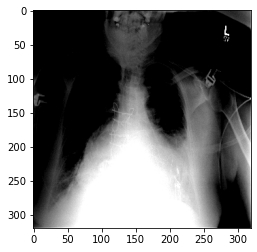

In [60]:
x, y = test

datagen = ImageDataGenerator(
                           samplewise_center=True,
                           samplewise_std_normalization=True,
                           dtype = 'int64')

img = next(datagen.flow(np.array([y[0]]), np.array([np.array([1, 0])]), batch_size=1))[0][0]

plt.imshow(img)
# x[0]
# print(x[0])
# y[0]

model.predict(np.array([img]))
print(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([[[-2.776232  , -2.776232  , -2.776232  ],
        [-2.815982  , -2.815982  , -2.815982  ],
        [-2.8358572 , -2.8358572 , -2.8358572 ],
        ...,
        [ 0.66215307,  0.66215307,  0.66215307],
        [ 0.66215307,  0.66215307,  0.66215307],
        [ 0.9602789 ,  0.9602789 ,  0.9602789 ]],

       [[-2.815982  , -2.815982  , -2.815982  ],
        [-2.8358572 , -2.8358572 , -2.8358572 ],
        [-2.8358572 , -2.8358572 , -2.8358572 ],
        ...,
        [ 0.4037773 ,  0.4037773 ,  0.4037773 ],
        [ 0.4037773 ,  0.4037773 ,  0.4037773 ],
        [ 0.66215307,  0.66215307,  0.66215307]],

       [[-2.8358572 , -2.8358572 , -2.8358572 ],
        [-2.8358572 , -2.8358572 , -2.8358572 ],
        [-2.8358572 , -2.8358572 , -2.8358572 ],
        ...,
        [ 0.38390225,  0.38390225,  0.38390225],
        [ 0.4037773 ,  0.4037773 ,  0.4037773 ],
        [ 0.66215307,  0.66215307,  0.66215307]],

       ...,

       [[ 0.32427707,  0.32427707,  0.32427707],
        [ 0

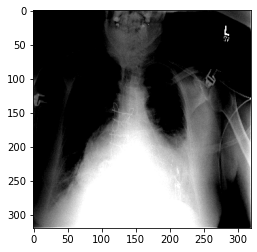

In [67]:
datagen = ImageDataGenerator(
                           samplewise_center=True,
                           samplewise_std_normalization=True)

img = next(datagen.flow(np.array([x]), np.array([np.array([1, 0])]), batch_size=1))[0][0]
plt.imshow(img)
img

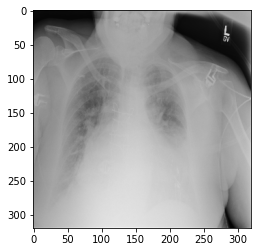

In [195]:
res_data = data#.reshape((data.shape[0],) + IMG_SIZE + (3,))
plt.imshow(res_data[0])

### Change channels to NHWC format (num_samples, height, width, channels)

In [196]:
# IMPORTANT: Change channels to channels_last so it will load in correctly when using DenseNet!
tf.keras.backend.set_image_data_format('channels_last') 
tf.keras.backend.image_data_format()

'channels_last'

### Create Data Generators

In [197]:
# testing cell

import time

mg = data[6].reshape(1, 320, 320, 3)

datagen = ImageDataGenerator(
                                   rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   fill_mode='nearest',
                                   samplewise_center=True,
                                   samplewise_std_normalization=True,
                                   dtype = 'int64',
                                   data_format = 'channels_first'
)

train_batches = datagen.flow(data, labels, batch_size=5, shuffle=True)
train_data, train_labels = next(train_batches)

print(data.shape, train_data.shape)
# train_data = train_data.reshape((train_data.shape[0],) + (3,) + IMG_SIZE)
# print(train_data.shape, train_labels.shape)

# print(train_data[0].reshape(320, 320, 3).shape)
# plt.imshow(train_data[0].reshape(320, 320, 3))#.astype('uint8')) # IMPORTANT: CAN TAKE OUT UINT8 IF YOU UNCOMMENT TRANSFORMATION IN DATAGEN. GETS ORIGINAL IMAGE
# plt.show()


# aug_iter = datagen.flow(img, batch_size=1)

# # generate samples and plot
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# # generate batch of images
# for i in range(3):

#     # convert to unsigned integers
#     temp = next(aug_iter)[0]
# #     print(temp)
#     image = temp.astype('uint8')
 
#     # plot image
#     ax[i].imshow(image)
#     ax[i].axis('off')

(1713, 320, 320, 3) (5, 320, 320, 3)


### Data Aug Function

In [198]:
def datagen(model, x_train, y_train, x_val, y_val, NUM_EPOCHS, BATCH_SIZE, callback): 
    
    train_datagen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       channel_shift_range=10,
                                       fill_mode='nearest',
                                       samplewise_center=True,
                                       samplewise_std_normalization=True,
                                       dtype = 'int64',
#                                        data_format = 'channels_first',
                                      )

    train_batches = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
#     train_data, train_labels = next(train_batches)
#     train_data = train_data.reshape((train_data.shape[0],) + (3,) + IMG_SIZE)
#     print(f'Generated {len(train_data)} train images.')
    
    val_datagen = ImageDataGenerator(samplewise_center=True,
                                     samplewise_std_normalization=True,
                                     dtype = 'int64',
#                                      data_format = 'channels_first',
                                    )
    
    val_batches = val_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, shuffle=False)
#     val_data, val_labels = next(val_batches)
#     val_data = val_data.reshape((val_data.shape[0],) + (3,) + IMG_SIZE)

# #print sample
#     print(train_data[0].reshape(320, 320, 3).shape)
#     plt.imshow(train_data[0].reshape(320, 320, 3))
#     plt.show()
    
#     val_idx = 4
#     print(val_data[val_idx].reshape(320, 320, 3).shape)
#     plt.imshow(val_data[val_idx].reshape(320, 320, 3))
#     plt.show()
    
#     history = model.fit(train_data,
#                         train_labels,
# #                         steps_per_epoch = int(len(y_train) // BATCH_SIZE),
#                         validation_data = val_data,
# #                         validation_steps = int(len(y_val) // BATCH_SIZE),
#                         batch_size = BATCH_SIZE,
#                         epochs = NUM_EPOCHS,
#                         verbose=1,
#                         callbacks=callback)

    history = model.fit_generator(train_batches,
                            steps_per_epoch = int(len(y_train) // BATCH_SIZE),
                            validation_data = val_batches,
                            validation_steps = int(len(y_val) // BATCH_SIZE),
                            epochs = NUM_EPOCHS,
                            verbose=1,
                            callbacks=callback)
    return history



### Split into train, test, val

In [199]:
# mini_X_train, mini_y_train = X_train[:100], y_train[:100]
x_train_and_val, x_test, y_train_and_val, y_test = train_test_split(data, labels, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train_and_val, y_train_and_val, test_size=0.11)

print('Train size:', x_train.shape[0])
print('Validation size:', x_val.shape[0])
print('Test size:', x_test.shape[0])

Train size: 1371
Validation size: 170
Test size: 172


In [200]:
# print class distributions
print('Train distribution:\n', pd.Series([str(y) for y in y_train]).value_counts())
print('Test distribution:\n', pd.Series([str(y) for y in y_test]).value_counts())

Train distribution:
 [0 1]    709
[1 0]    662
dtype: int64
Test distribution:
 [0 1]    89
[1 0]    83
dtype: int64


### Define Model

In [213]:
# create the base pre-trained model
base_model = DenseNet121(
    weights='/home/ec2-user/SageMaker/Cardiomegaly /densenet.hdf5', 
    include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(2, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [203]:
# input = Input(shape=(None, , 720, 3), name='image_input')
# base_model.summary()

In [204]:
# !nvidia-smi --query-gpu=memory.used --format=csv

memory.used [MiB]
16156 MiB


### Transform and Fit Model

In [211]:
y_val.shape

(170, 2)

In [214]:
EPOCHS = 10
BATCH_SIZE = 4

model_history = datagen(model, x_train, y_train, x_val, y_val, EPOCHS, BATCH_SIZE, [])

/tmp/ipykernel_3741/426432164.py:51: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_batches,


Epoch 1/10
342/342 [==============================] - 72s 178ms/step - loss: 0.7495 - accuracy: 0.5494 - val_loss: 18.0789 - val_accuracy: 0.4405
Epoch 2/10
342/342 [==============================] - 59s 171ms/step - loss: 0.7152 - accuracy: 0.5596 - val_loss: 2.6013 - val_accuracy: 0.4940
Epoch 3/10
342/342 [==============================] - 58s 171ms/step - loss: 0.7058 - accuracy: 0.5735 - val_loss: 2.2485 - val_accuracy: 0.5000
Epoch 4/10
342/342 [==============================] - 58s 170ms/step - loss: 0.6970 - accuracy: 0.5845 - val_loss: 0.7841 - val_accuracy: 0.5179
Epoch 5/10
342/342 [==============================] - 59s 171ms/step - loss: 0.6704 - accuracy: 0.6181 - val_loss: 1.4158 - val_accuracy: 0.5060
Epoch 6/10
342/342 [==============================] - 58s 171ms/step - loss: 0.6525 - accuracy: 0.6313 - val_loss: 0.8100 - val_accuracy: 0.5476
Epoch 7/10
342/342 [==============================] - 59s 171ms/step - loss: 0.6468 - accuracy: 0.6467 - val_loss: 0.5062 - val_a

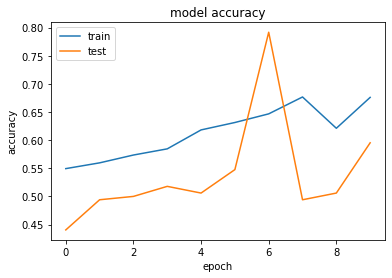

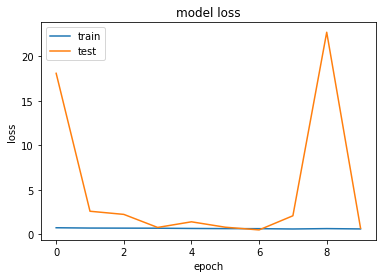

In [217]:
# summarize history for accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [218]:
train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   fill_mode='nearest',
                                   samplewise_center=True,
                                   samplewise_std_normalization=True,
                                   dtype = 'int64',
                                  )
train_batches = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
train_eval = model.evaluate_generator(train_batches, steps = len(train_batches))
print(f'Train loss: {train_eval[0]}, Train accuracy: {train_eval[1]}')

val_datagen = ImageDataGenerator(samplewise_center=True,
                                 samplewise_std_normalization=True,
                                 dtype = 'int64',
                                )
val_batches = val_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, shuffle=False)
val_eval = model.evaluate_generator(val_batches, steps = len(val_batches))
print(f'Validation loss: {val_eval[0]}, Validation accuracy: {val_eval[1]}')

# val and test have the same transformations
test_batches = val_datagen.flow(x_test, y_test, batch_size=BATCH_SIZE, shuffle=False)
test_eval = model.evaluate_generator(test_batches, steps = len(test_batches))
print(f'Test loss: {test_eval[0]}, Test accuracy: {test_eval[1]}')

/tmp/ipykernel_3741/1785479581.py:13: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_eval = model.evaluate_generator(train_batches, steps = len(train_batches))


Train loss: 0.7323919534683228, Train accuracy: 0.6017505526542664


/tmp/ipykernel_3741/1785479581.py:21: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_eval = model.evaluate_generator(val_batches, steps = len(val_batches))


Validation loss: 0.7319290637969971, Validation accuracy: 0.5882353186607361


/tmp/ipykernel_3741/1785479581.py:30: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_eval = model.evaluate_generator(test_batches, steps = len(test_batches))


Test loss: 0.6620050668716431, Test accuracy: 0.6511628031730652
